In [1]:
import os
base_path = r"C:\Users\ndrmon\Anaconda3"
path = os.pathsep.join([os.path.join(base_path, i) for i in [r"", r"bin", r"Scripts", r"Library\mingw-w64\bin", r"Library\bin"]])
os.environ["PATH"]+=os.pathsep+path

In [2]:
import numpy as np
import pandas as pd
import simpy 
import matplotlib.pyplot as plt
import itertools
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import simpy 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
from IPython.display import HTML
import warnings
import mercury as mr
warnings.simplefilter(action='ignore', category=FutureWarning)


# Warteschlangen bei Intesive Kontrollen bei N-KOs

In [3]:
import warnings
import mercury as mr
import plotly.express as px
import pandas as pd
warnings.simplefilter(action='ignore', category=Warning)


In [4]:

# set Application parameters
# set Application parameters
app = mr.App(title="STI Simulation App",
        description="Warteschlangen bei Intensive Kontrollen bei N-KOs",
        show_code=False,
        show_prompt=True,
        continuous_update=False,
        static_notebook=False,
        show_sidebar=True,
        full_screen=True,
        allow_download=True)

mercury.App

In [5]:
def RunSim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME,NUM_RUNS,video_flag='N'):
   
    import numpy as np
    import pandas as pd
    import simpy 
    import matplotlib.pyplot as plt
    import itertools
    from IPython import display
    import pandas as pd
    import numpy as np
    from ipywidgets import interactive
    import matplotlib.pyplot as plt
    import numpy as np
    from ipywidgets import interact, interactive, fixed, interact_manual
    import ipywidgets as widgets
    import simpy 
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import itertools
    from IPython.display import HTML
    import warnings
    #import mercury as mr

    def TicketVerkaufSim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME):
            """A station has a limited number of Fahrscheinautomaten (``NUM_MACHINES``) to
        sellt eh tickets in parallel.

        Fahrgast has to request one of the machines. When they got one, they
        can start the buying processes and wait for it to finish (which
        is described by the Possion distribution as well)."""

            import random
            


            def generate_fg(FGZ_PRO_MIN):
                return np.random.exponential(1.0/FGZ_PRO_MIN) # 10 customer per minute 
            #poisson_random_measure


            def assign_fsa(TICKET_PRO_MIN):
                return np.random.exponential(1.0/TICKET_PRO_MIN) # serve 2 customer per minute 


            #waiting time        
            wait_t={}       
            queues = []
            arr_t=[]    
            fg_ankommen={}
            service_t={}
            start_t={}
            choices={}
            fg_beended={}

            def fg(env,fg, fsas):
                        t_arrival=env.now
                        fg_ankommen[fg]=t_arrival
                        Qlength = {i:NoInSystem(fsas[i]) for i in range(len(fsas))}
                        queues.append({q:len(fsas[q].put_queue) for q in range(len(fsas))})

                        choice=[k for k,v in sorted(Qlength.items(), key=lambda a:a[1])][0]
                        choices[fg]=(choice)

                        with fsas[choice].request() as request:              
                            yield request
                            t_service=env.now
                            start_t[fg]=(t_service)

                            wait_t[fg]=(t_service-t_arrival)

                            yield env.timeout(assign_fsa(TICKET_PRO_MIN))
                            queues.append({i: len(fsas[i].put_queue) for i in range(len(fsas))})

                            t_depart=env.now
                            service_t[fg]=(t_depart-t_service)

                            fg_beended[fg]=fg


            
            def fsa_run(env):
                i=0
                while True:
                    i+=1
                    yield env.timeout(generate_fg(FGZ_PRO_MIN))
                    env.process(fg(env,i, fsas))

            def NoInSystem(f):
                """Total number of customers in the resource R"""
                return max([0, len(f.put_queue) + len(f.users)])

            
            
            ###Simulation part

            #np.random.seed(RANDOM_SEED) 
            np.random.seed() 

            env=simpy.Environment()
            #generate resources
            fsas={i: simpy.Resource(env) for i in range(NUM_FSA)}
            #run
            env.process(fsa_run(env))
            env.run(until=SIM_TIME)
            
            return wait_t, queues , arr_t, fg_ankommen,service_t,start_t, choices, fg_beended
        
    def create_output(fg_ankommen,start_t,choices,service_t,wait_t,fg_beended,SIM_TIME,NUM_FSA):
        def dfconverter(dict,column,i):
            temp=pd.DataFrame(dict, index=[0]).T.reset_index()
            temp.columns=['fg',column]
            dictlist[i]=temp


        listCol=['arr_t','start_t','fsa','service_t','wait_t','fg_beended']
        listDict=[fg_ankommen,start_t,choices,service_t,wait_t,fg_beended]

        dictlist={}
        for i,x in enumerate(listDict):
            dfconverter(x,listCol[i],i)  
            
        df=dictlist[0].merge(dictlist[1], how='left',on='fg').merge(dictlist[2], how='left',on='fg').merge(dictlist[3], how='left',on='fg').merge(dictlist[4], how='left',on='fg').merge(dictlist[5], how='left',on='fg').sort_values(by='fg')
        ## fg noch in schlange:
        fg_ohne_t=len(df[df['wait_t'].isna()])

        if fg_ohne_t>0:
            ratio_fg_sch=len(df[df['wait_t'].isna()])/len(df)*100
        else:
            ratio_fg_sch=0

        df['ratio_fg_sch']=ratio_fg_sch
        df['fg_ohne_t']=fg_ohne_t

        df['wait_t_cl']=np.where(df['wait_t'].isna(),SIM_TIME-df['arr_t'],df['wait_t']) 
        df['start_t_cl']=np.where(((df['service_t'].isna()) & (~df['service_t'].isna())),SIM_TIME-df['start_t'],df['start_t']) 

        #df['wait_t']=df.start_t-df.arr_t
        for i in range(NUM_FSA):
            df['start_t_'+str(i)]=np.where(df['fsa']==i,df['start_t_cl'],0)
            df['service_t_'+str(i)]=np.where(df['fsa']==i,df['service_t'],0) 
        df['wait_mean_sr']=df['wait_t'].mean()
        return df
        
    def mc_sim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME,NUM_RUNS=100):
        output_sim={}
        queues_dict={}
        for i in range(0,NUM_RUNS):
            wait_t, queues , arr_t, fg_ankommen,service_t,start_t, choices, fg_beended=TicketVerkaufSim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME)
            output_sim[i]=create_output(fg_ankommen,start_t,choices,service_t,wait_t,fg_beended,SIM_TIME,NUM_FSA)
            queues_dict[i]=queues
        return output_sim,queues_dict

    def bericht(df_output,NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME):
        print('Anzahl FG pro Min:' + str(FGZ_PRO_MIN))
        print('Anzahl Konrollorgane:'+ str(NUM_FSA))
        print('Anzahl Kontrolle pro Minute bei 1.KO:'+ str(TICKET_PRO_MIN))

        print('Anzahl FG ohne Kontrolle nach '+ str(SIM_TIME) + ' Minuten:' + str(df_output.fg_ohne_t.mean())+ ' ('+ format(df_output.ratio_fg_sch.mean(),".2f")+'%)')

        print('Druchnitliche Wartezeit in Minuten: '+ format(df_output['wait_t_cl'].mean(),".2f"))
        
    
    def plots(df_output,NUM_FSA,NUM_RUNS):  
        import seaborn as sns

        sns.set_style("whitegrid")



        ### Average Queue Time


        fig = plt.figure( figsize=(25,15))
        temp=df_output[df_output['sim_nr']==0]
        plt.barh(
            y=temp.fg,
            left=temp.arr_t,
            width=temp.wait_t_cl,
            alpha=1.0,
            color="gainsboro", label='Wartezeit')
        for i in range(NUM_FSA):
            plt.barh(
                y=temp.fg,
                left=temp['start_t_'+str(i)],
                width=temp['service_t_'+str(i)],
                alpha=1.0,
              label='Zeit beim KO '+str(i+1))

        plt.legend()
        # Set common labels
        plt.xlabel('Zeit[min]')
        plt.ylabel('FG Nummer')
        #axes[0].yticks(df.fg.unique().tolist())
        plt.show()
        plt.clf()
    def Video(queues_dict,df_output,NUM_FSA,video_flag):
            ### Queues

            q = pd.DataFrame(queues_dict[0])
            temp=df_output[df_output['sim_nr']==0]

            if video_flag=='Y':
                %matplotlib notebook
                %matplotlib inline

                #plt.ioff()
                # animation function 
                numbers = list(itertools.chain(range(0, len(temp))))

                x=[]
                y={}
                for j in range(NUM_FSA):
                    y[j]=[]
                fig3, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
                legend_list=[]
                def animate(i):

                    x.append(numbers[i])
                    for j in range(NUM_FSA):
                        y[j].append((q[j][i]))
                        axes.plot(x, y[j])
                        legend_list.append('FSA'+str(j+1))
                    axes.legend(set(legend_list))

                plt.title("IK Schlangenaufbau")
                plt.xlabel('FG')
                plt.ylabel('Anzahl FG in der Schlange bei KO')
                # call the animator	 
                anim = animation.FuncAnimation(fig3, animate, frames=len(temp), interval=800, repeat=False)
                video = anim.to_html5_video()
                html = display.HTML(video)
                display.display(html)

                plt.close()
            else:
                
                legend_list=[]
                pd.DataFrame(q).plot(figsize=(20, 5))
                
                for j in range(NUM_FSA):
                    legend_list.append('KO'+str(j+1))
                    
                plt.legend(set(legend_list))

                plt.title("IK Schlangenaufbau")
                plt.xlabel('FG')
                plt.ylabel('Anzahl FG in der Schlange bei KO')
                plt.show()
            

    
    output_sim,queues_dict=mc_sim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME,NUM_RUNS)
    
    df_output=pd.concat(output_sim).reset_index().drop('level_1', axis=1).rename(columns={'level_0':'sim_nr'})
        
    bericht(df_output,NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME) 
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plots(df_output,NUM_FSA,NUM_RUNS)
    Video(queues_dict,df_output,NUM_FSA,video_flag='N')



In [9]:
NUM_FSA = mr.Slider(value=9, min=4, max=50, label="Anzahl der Kontrollorganen", step=1)
FGZ_PRO_MIN= mr.Slider(value=30, min=1, max=100, label="Anzahl der Fahrgaeste pro Minute (Ankunft)", step=1)
SIM_TIME= mr.Slider(value=5, min=2, max=20, label="Zeitraum", step=1)
TICKET_PRO_MIN=mr.Slider(value=3, min=1, max=30, label="Anzahl der kontrollierten FG pro Minute", step=1)
NUM_RUNS=mr.Slider(value=10, min=1, max=10000, label="Anzahl Simulationen", step=1)

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

In [10]:
#video_flag = mr.Select(value="N", choices=['N','Y'], label="Video")


Anzahl FG pro Min:30
Anzahl Konrollorgane:9
Anzahl Kontrolle pro Minute bei 1.KO:3
Anzahl FG ohne Kontrolle nach 5 Minuten:28.98637248539909 (18.04%)
Druchnitliche Wartezeit in Minuten: 0.44


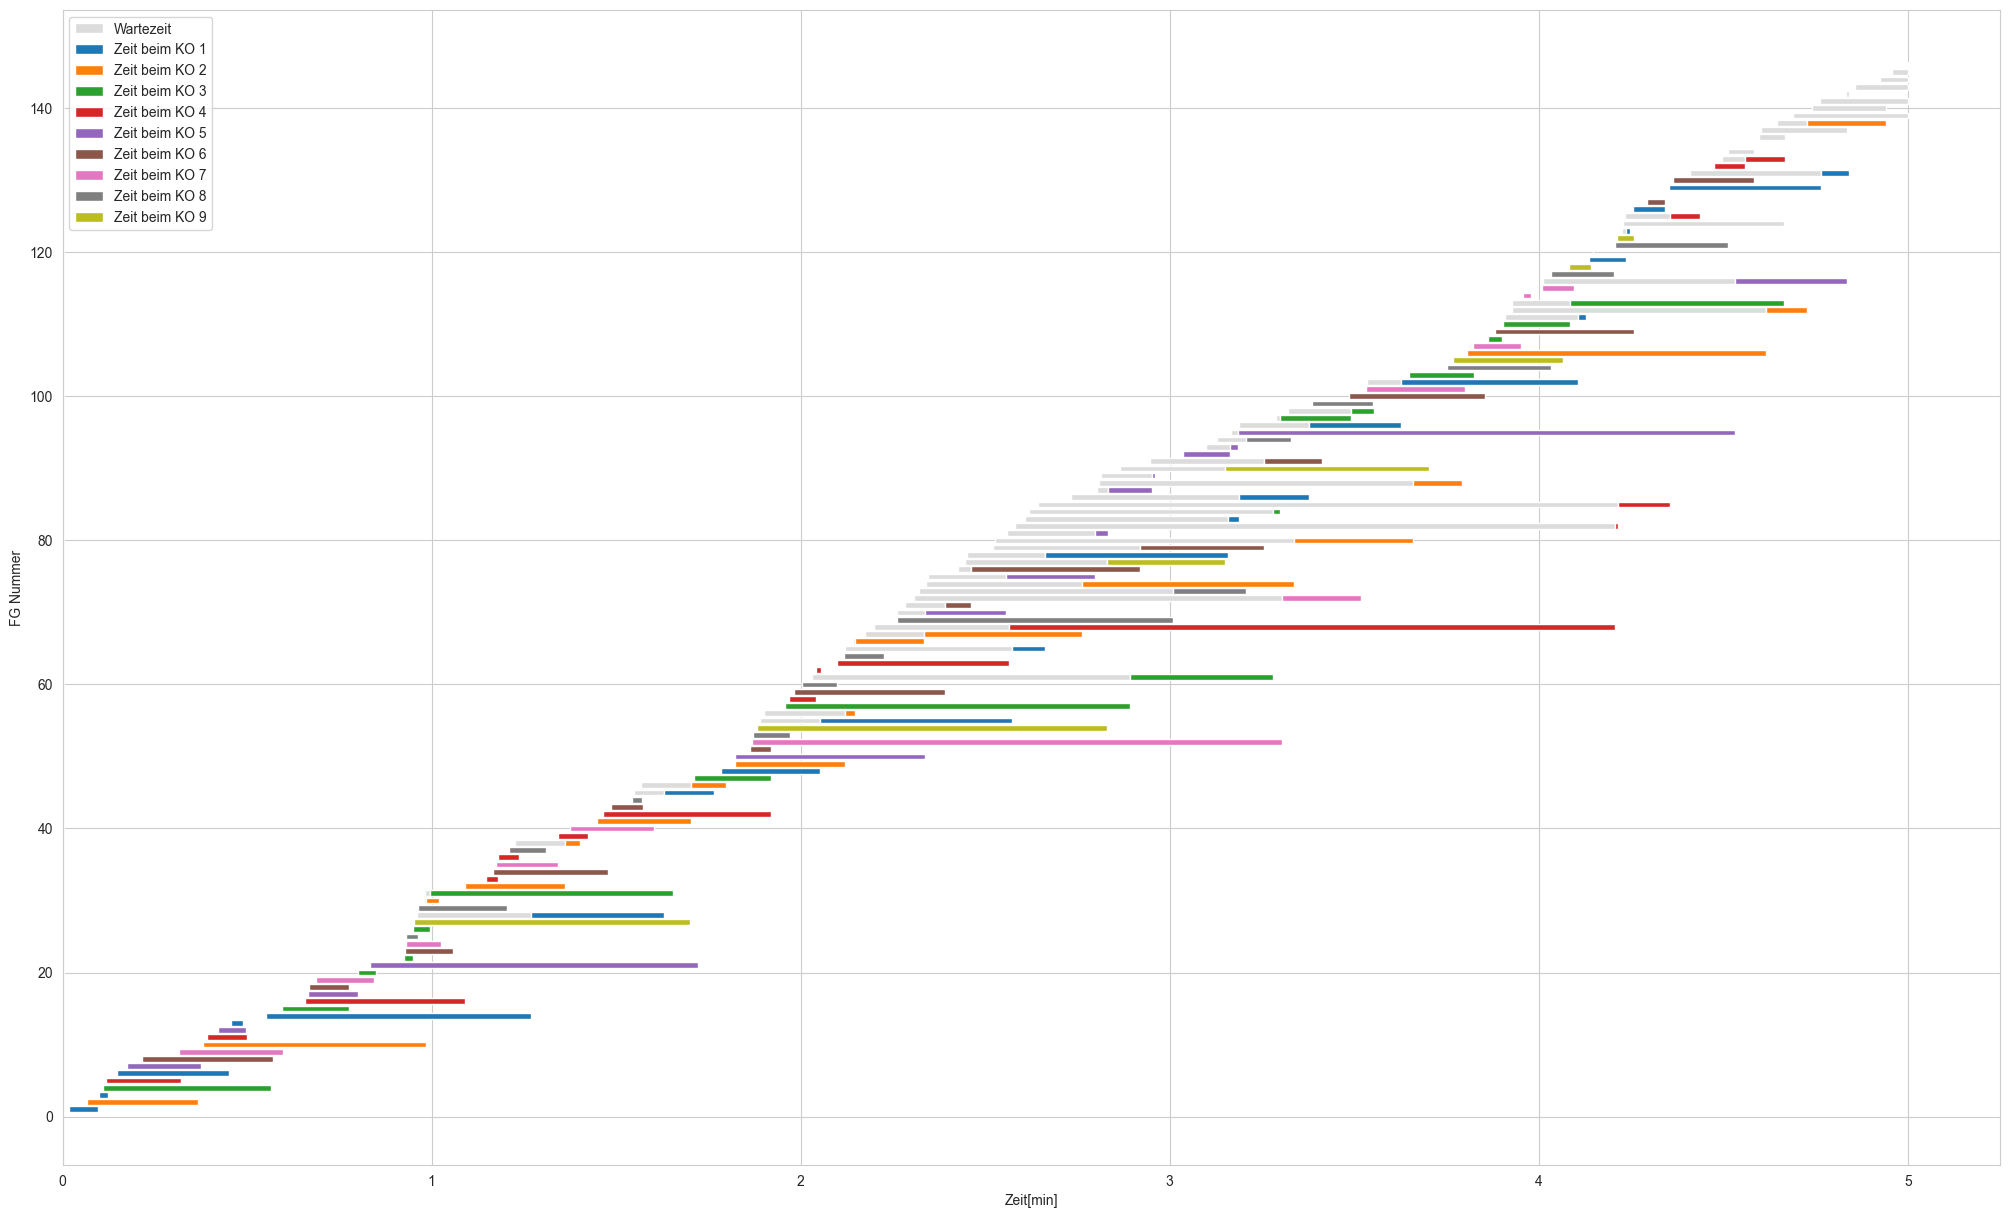

<Figure size 640x480 with 0 Axes>

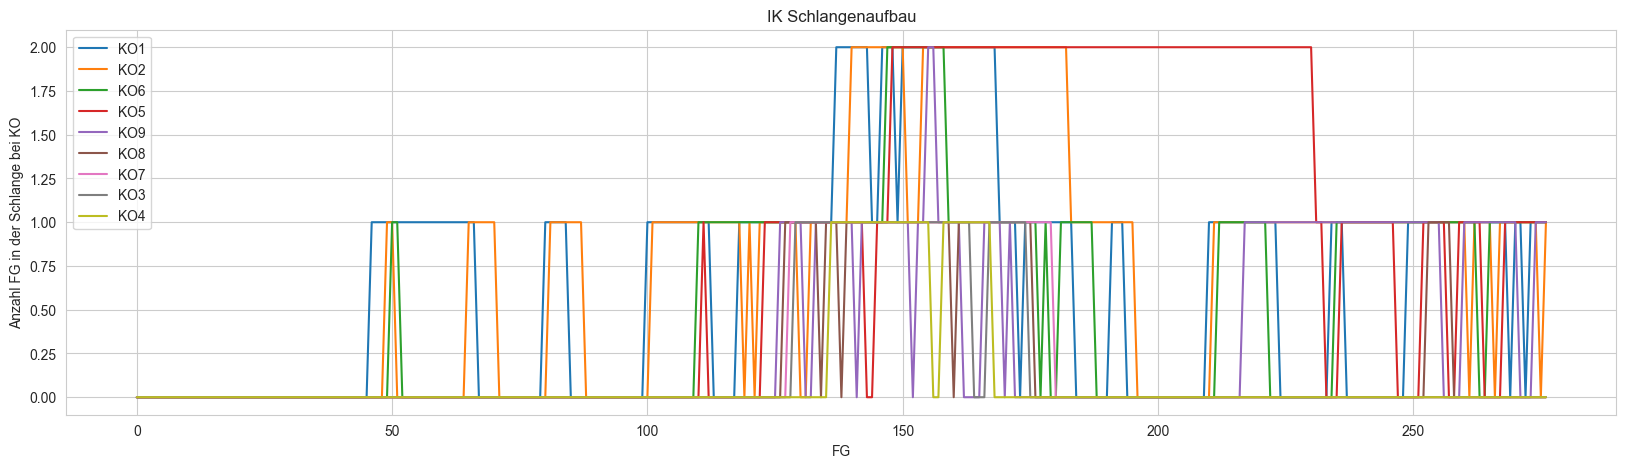

In [11]:
%matplotlib notebook
%matplotlib inline
RunSim(NUM_FSA.value,FGZ_PRO_MIN.value,TICKET_PRO_MIN.value,SIM_TIME.value,NUM_RUNS.value,video_flag='N')